In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [8]:
# Load datasets
crimes = pd.read_csv("../data/NYPD_CrimeData/Preprocessed_forsquare_nyc_alligned_subset_data.csv")
checkins = pd.read_csv("../data/NYC_checkins/raw/checkins_with_crimes.csv")

# Load holidays data
holidays = pd.read_csv("../data/NYC_checkins/extra_data_to_combine/holidays_2012.csv")

# You can switch between these weather sources if needed
weather_hist = pd.read_csv("../data/NYC_checkins/extra_data_to_combine/weatherHistory.csv")
temperature = pd.read_csv("../data/NYC_checkins/extra_data_to_combine/temperature.csv")
weather_desc = pd.read_csv("../data/NYC_checkins/extra_data_to_combine/weather_description.csv")



In [10]:
print("crimes.columns\n",crimes.columns, "\ncheckins\n",checkins.columns, "\nholidays.columns\n",holidays.columns, "\nweather_hist.columns\n",weather_hist.columns, "\ntemperature.columns\n",temperature.columns, "\nweather_desc.columns\n",weather_desc.columns)

crimes.columns
 Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT',
       'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME',
       'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'complaint_date_start',
       'complaint_date_end'],
      dtype='object') 
checkins
 Index(['user_id', 'poi_id', 'poi_category_id', 'poi_category_name', 'latitude',
       'longitude', 'timezone_offset', 'utc_time', 'local_time', 'crimes',
       'violations', 'misdemeanors', 'felonies'],
      dtype='object') 
holidays.columns
 Index(['Date', 'Day', 'Holiday_Name', 'Region/Category', 'Context/Note'], dtype='object') 
we

In [3]:
# crimes

# Crimes date
crimes["date"] = pd.to_datetime(crimes["complaint_date_start"], errors="coerce").dt.date

# Holidays date
holidays["date"] = pd.to_datetime(holidays["Date"], errors="coerce").dt.date
holidays["is_holiday"] = 1


## dots map graph colored in green to red range according to the number og crimes that occurred during the range of check-ins for a pio
1. For each POI, compute the start and end time of its check ins.
2. Count how many crimes occurred within that temporal window.
3. Plot POIs as dots using latitude and longitude.
4. Color dots using a green to red scale based on crime count.

In [12]:
# --- Ensure correct datetime types ---
checkins["utc_time"] = pd.to_datetime(checkins["utc_time"], errors="coerce")
crimes["complaint_date_start"] = pd.to_datetime(
    crimes["complaint_date_start"], errors="coerce"
)

In [13]:
# --- Step 1: POI check-in time window ---
poi_time_window = (
    checkins
    .groupby("poi_id")["utc_time"]
    .agg(start_time="min", end_time="max")
    .reset_index()
)

In [20]:
# --- Step 2: POI coordinates ---
# Coordinates and category per POI (first non null)
poi_meta = (
    checkins.sort_values("utc_time")
    .groupby("poi_id")[["latitude", "longitude", "poi_category_name"]]
    .first()
    .reset_index()
)

In [21]:
poi_df = poi_time_window.merge(poi_meta, on="poi_id", how="left")

# --- Step 3: Count crimes per POI within its time range ---
# Ensure complaint_date_start is timezone-aware (UTC) so comparisons with
# the tz-aware start/end times from checkins do not raise TypeError.
_c = crimes["complaint_date_start"]
if _c.dt.tz is None:
    crimes["complaint_date_start"] = _c.dt.tz_localize("UTC")
else:
    crimes["complaint_date_start"] = _c.dt.tz_convert("UTC")

def count_crimes(row):
    start = row["start_time"]
    end = row["end_time"]
    mask = (crimes["complaint_date_start"] >= start) & (crimes["complaint_date_start"] <= end)
    return int(mask.sum())

poi_df["crime_count"] = poi_df.apply(count_crimes, axis=1)

In [23]:
# Clean rows without coordinates
poi_df = poi_df.dropna(subset=["latitude", "longitude"]).copy()
poi_df

,poi_id,start_time,end_time,latitude,longitude,poi_category_name,crime_count
0,0,2012-04-04 23:31:31+00:00,2012-07-28 20:45:04+00:00,40.781558,-73.975792,Seafood Restaurant,163973
1,1,2012-04-07 17:42:24+00:00,2013-02-02 22:37:59+00:00,40.784018,-73.974524,American Restaurant,409482
2,2,2012-04-08 12:33:39+00:00,2012-04-10 03:59:21+00:00,40.739398,-73.993210,General Entertainment,1861
3,3,2012-04-08 20:02:10+00:00,2012-12-09 18:23:28+00:00,40.785677,-73.976498,American Restaurant,339440
4,4,2012-04-09 16:20:52+00:00,2013-02-06 00:53:07+00:00,40.719929,-74.008532,Breakfast Spot,410684
...,...,...,...,...,...,...,...
38328,38328,2012-09-14 22:34:02+00:00,2012-09-14 22:34:02+00:00,40.745893,-73.992693,Office,0
38329,38329,2012-11-20 14:50:31+00:00,2013-01-30 14:00:55+00:00,40.734641,-73.979287,Bus Station,88579
38330,38330,2012-12-03 14:41:26+00:00,2012-12-03 14:41:26+00:00,40.751666,-74.005777,Office,0
38331,38331,2012-12-08 03:50:12+00:00,2012-12-08 03:50:12+00:00,40.725580,-73.977576,Pizza Place,0


In [24]:
import folium
from folium import FeatureGroup
from folium.plugins import MarkerCluster
import branca.colormap as cm
import numpy as np

In [ ]:
# Center NYC
nyc_center = [40.7128, -74.0060]

m = folium.Map(location=nyc_center, zoom_start=11, tiles="CartoDB positron")

# Continuous colormap green to red
max_c = int(poi_df["crime_count"].max()) if len(poi_df) else 0
colormap = cm.LinearColormap(["green", "yellow", "red"], vmin=0, vmax=max(1, max_c))
colormap.caption = "Number of crimes (during POI check-in time window)"
colormap.add_to(m)

# Define filter bins (edit as you like)
bins = [0, 1, 5, 20, 50, np.inf]
bin_labels = [
    "0",
    "1 to 4",
    "5 to 19",
    "20 to 49",
    "50+"
]

# Create one toggleable layer per bin
layers = []
for label in bin_labels:
    fg = FeatureGroup(name=f"Crimes: {label}", show=True)
    cluster = MarkerCluster().add_to(fg)
    layers.append((fg, cluster))
    fg.add_to(m)

def bin_index(x):
    for i in range(len(bins) - 1):
        if bins[i] <= x < bins[i + 1]:
            return i
    return len(bin_labels) - 1

# Add markers
for _, r in poi_df.iterrows():
    ccount = int(r["crime_count"])
    idx = bin_index(ccount)
    fg, cluster = layers[idx]

    color = colormap(ccount)

    tooltip_html = (
        f"POI category: {r.get('poi_category_name', 'Unknown')}<br>"
        f"Crimes: {ccount}"
    )

    folium.CircleMarker(
        location=[float(r["latitude"]), float(r["longitude"])],
        radius=6,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.85,
        weight=1,
        tooltip=folium.Tooltip(tooltip_html, sticky=True),
    ).add_to(cluster)

# Layer toggles
folium.LayerControl(collapsed=False).add_to(m)

# Save to HTML
m.save("nyc_poi_crime_map.html")

: 

In [18]:
# --- Step 4: Plot ---
cmap = LinearSegmentedColormap.from_list(
    "green_to_red",
    ["green", "yellow", "red"]
)

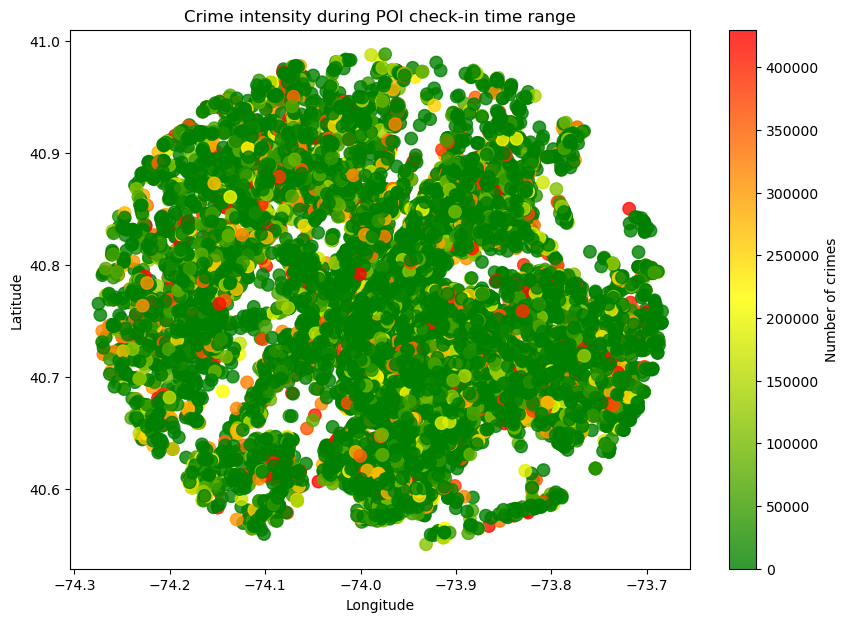

In [19]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    poi_df["longitude"],
    poi_df["latitude"],
    c=poi_df["crime_count"],
    cmap=cmap,
    s=80,
    alpha=0.8
)

plt.colorbar(scatter, label="Number of crimes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Crime intensity during POI check-in time range")
plt.show()

tmp

In [4]:
daily_crimes = (
    crimes.dropna(subset=["date", "CMPLNT_NUM"])
          .groupby("date", as_index=False)
          .agg(crimes=("CMPLNT_NUM", "nunique"))
)


In [5]:
def to_daily_weather(df: pd.DataFrame, label: str) -> pd.DataFrame:
    df = df.copy()

    # Find a datetime-like column
    datetime_candidates = ["datetime", "dt", "time", "date", "Date", "timestamp"]
    dt_col = next((c for c in datetime_candidates if c in df.columns), None)
    if dt_col is None:
        raise ValueError(f"{label}: could not find a datetime column. Columns are: {list(df.columns)}")

    df["date"] = pd.to_datetime(df[dt_col], errors="coerce").dt.date
    df = df.dropna(subset=["date"])

    # Find a temperature-like column
    temp_candidates = ["temperature", "temp", "temp_mean", "Temperature"]
    temp_col = next((c for c in temp_candidates if c in df.columns), None)

    out = df[["date"]].drop_duplicates().sort_values("date")

    if temp_col is not None:
        df[temp_col] = pd.to_numeric(df[temp_col], errors="coerce")
        daily_temp = (
            df.dropna(subset=[temp_col])
              .groupby("date", as_index=False)
              .agg(
                  temp_mean=(temp_col, "mean"),
                  temp_max=(temp_col, "max"),
                  temp_min=(temp_col, "min"),
              )
        )
        out = out.merge(daily_temp, on="date", how="left")

    # If there is a weather description column, take the mode per day
    desc_candidates = ["weather_description", "description", "Weather", "summary"]
    desc_col = next((c for c in desc_candidates if c in df.columns), None)
    if desc_col is not None:
        daily_desc = (
            df.groupby("date", as_index=False)
              .agg(weather_mode=(desc_col, lambda x: x.mode().iloc[0] if not x.mode().empty else None))
        )
        out = out.merge(daily_desc, on="date", how="left")

    return out


In [6]:
def to_daily_weather(df: pd.DataFrame, label: str) -> pd.DataFrame:
    df = df.copy()

    # Find a datetime-like column
    datetime_candidates = ["datetime", "dt", "time", "date", "Date", "timestamp", "Formatted Date"]
    dt_col = next((c for c in datetime_candidates if c in df.columns), None)
    if dt_col is None:
        raise ValueError(f"{label}: could not find a datetime column. Columns are: {list(df.columns)}")

    print( dt_col)
    print( df[dt_col].head())
    print(df[dt_col].dtype)

    df["date"] = pd.to_datetime(df[dt_col], errors="coerce").dt.date
    df = df.dropna(subset=["date"])

    # Find a temperature-like column
    temp_candidates = ["temperature", "temp", "temp_mean", "Temperature"]
    temp_col = next((c for c in temp_candidates if c in df.columns), None)

    out = df[["date"]].drop_duplicates().sort_values("date")

    if temp_col is not None:
        df[temp_col] = pd.to_numeric(df[temp_col], errors="coerce")
        daily_temp = (
            df.dropna(subset=[temp_col])
              .groupby("date", as_index=False)
              .agg(
                  temp_mean=(temp_col, "mean"),
                  temp_max=(temp_col, "max"),
                  temp_min=(temp_col, "min"),
              )
        )
        out = out.merge(daily_temp, on="date", how="left")

    # If there is a weather description column, take the mode per day
    desc_candidates = ["weather_description", "description", "Weather", "summary"]
    desc_col = next((c for c in desc_candidates if c in df.columns), None)
    if desc_col is not None:
        daily_desc = (
            df.groupby("date", as_index=False)
              .agg(weather_mode=(desc_col, lambda x: x.mode().iloc[0] if not x.mode().empty else None))
        )
        out = out.merge(daily_desc, on="date", how="left")

    return out


In [7]:
daily_weather = to_daily_weather(weather_hist, "weatherHistory")
daily_weather.head()


Formatted Date
0    2006-04-01 00:00:00.000 +0200
1    2006-04-01 01:00:00.000 +0200
2    2006-04-01 02:00:00.000 +0200
3    2006-04-01 03:00:00.000 +0200
4    2006-04-01 04:00:00.000 +0200
Name: Formatted Date, dtype: object
object


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001AEED5CD010>>
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
  File "c:\ProgramData\anaconda3\Lib\threading.py", line 1479, in enumerate
    def enumerate():
KeyboardInterrupt: 
C:\Users\nadda\AppData\Local\Temp\ipykernel_39340\1609080148.py:14: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["date"] = pd.to_datetime(df[dt_col], errors="coerce").dt.date


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
weather_hist.columns


Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary'],
      dtype='object')

In [ ]:
weather_hist.head(3)

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
